# Experiments

For a full description of the experimental setup, see the [documentation](../docs/experimental-setup.md).

In [1]:
# General setup
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Prepare a DataFrame to store the results
results = pd.DataFrame(columns=["scenario", "preference_criteria", "objectives", "solver", "utility"])

## Scenario 1: Preference Criteria are Superset of Objectives (SUP)

In this first scenario, we evaluate the maximum utility of the different adaptation techniques, if the objectives do not include all preference criteria in the true preference function.

In [2]:
import experiments.user
import experiments.problem

# Get MOO problem
SCENARIO_1_OBJECTIVES = ["neck", "shoulder"]
problem = experiments.problem.LayoutProblem(
    objectives=SCENARIO_1_OBJECTIVES
)

# Get utility function
SCENARIO_1_PREFERENCE_CRITERIA = ["neck", "shoulder", "torso"]
get_utility = experiments.user.get_utility_function(
    objectives=SCENARIO_1_PREFERENCE_CRITERIA,
    weights=1/3,
)

### Our Solver: U-NSGA-III w/ AASF

Our suggested solver uses the genetic U-NSGA-III algorithm with the AASF decomposition technique.

In [3]:
import experiments.pareto_solver

def get_utilities_of_pareto_optimal_adaptations(problem, get_utility, verbose = False):
    """Get the utilities of Pareto optimal adaptations."""
    pareto_solver = experiments.pareto_solver.ParetoSolver(problem, pop=100, n_gen=100, seed=42)
    pareto_front_adaptations = pareto_solver.get_adaptations()
    utilities = [get_utility(adaptation) for adaptation in pareto_front_adaptations]
    if verbose:
        print(f"Adaptations (Ours): {len(pareto_front_adaptations)} adaptations")
        print("Utilities (Ours):", utilities)
        print("Max Utility Adaptation (Ours):", pareto_front_adaptations[np.argmax(utilities)])
        print("Max Utility (Ours):", np.max(utilities))
    return utilities

utilities_for_pareto_front_adaptations = get_utilities_of_pareto_optimal_adaptations(problem, get_utility, verbose=True)
results = results.append({
    "scenario": "SUP",
    "preference_criteria": ", ".join(SCENARIO_1_PREFERENCE_CRITERIA),
    "objectives": ", ".join(SCENARIO_1_OBJECTIVES),
    "solver": "Ours",
    "utility": np.max(utilities_for_pareto_front_adaptations),
}, ignore_index=True)

Adaptations (Ours): 5 adaptations
Utilities (Ours): [0.8700231379722703, 0.8802704924179034, 0.8461635646145993, 0.8910355494073863, 0.8623806963310363]
Max Utility Adaptation (Ours): Layout(items=[Element(id='0', position=Position(x=-15.606332210073283, y=-13.628113330232878, z=-19.79615045376869), rotation=Rotation(x=0.43683948624245916, y=0.026316407425051758, z=0.12167580261783005, w=0.03575771701421536))])
Max Utility (Ours): 0.8910355494073863


### Baseline Solver 1: Static Weighted Sum (WS)

The first baseline solver is a static weighted sum with equal weights.

In [4]:
import experiments.weighted_sum_solver

def get_utility_of_equally_weighted_sum_adaptation(problem, get_utility, verbose = False):
    """Get the utility of the equally weighted sum adaptation."""
    equally_weighted_sum_solver = experiments.weighted_sum_solver.WeightedSumSolver(problem, weights=1/problem.n_obj, seed=42)
    equally_weighted_sum_adaptation = equally_weighted_sum_solver.get_adaptations()[0]
    equally_weighted_sum_utility = get_utility(equally_weighted_sum_adaptation)
    if verbose:
        print("Equally Weighted Sum Adaptation:", equally_weighted_sum_adaptation)
        print("Equally Weighted Sum Utility:", equally_weighted_sum_utility)
    return equally_weighted_sum_utility

equally_weighted_sum_utility = get_utility_of_equally_weighted_sum_adaptation(problem, get_utility, verbose=True)
results = results.append({
    "scenario": "SUP",
    "preference_criteria": ", ".join(SCENARIO_1_PREFERENCE_CRITERIA),
    "objectives": ", ".join(SCENARIO_1_OBJECTIVES),
    "solver": "WS",
    "utility": equally_weighted_sum_utility,
}, ignore_index=True)

Equally Weighted Sum Adaptation: Layout(items=[Element(id='0', position=Position(x=2.360711458713962, y=-19.79942493019234, z=-4.159182935835284), rotation=Rotation(x=0.1789992668156376, y=0.8194682865399235, z=0.362520192557711, w=0.012605916234388281))])
Equally Weighted Sum Utility: 0.8461635646145993


### Baseline Solver 2: Multiple Single-Objective Solvers (MSO)

The second baseline solver is a single-objective solver that is used for all objectives in the utility function.

### Baseline Solver 3: Random Solver (RND)

The third baseline solver is a random solver that returns a random adaptation.

In [5]:
import experiments.random_solver

def get_utility_of_random_adaptation(problem, get_utility, verbose = False):
    """Get the utility of a random adaptation."""
    random_solver = experiments.random_solver.RandomSolver(problem=problem, seed=42)
    random_adaptation = random_solver.get_adaptations(n_adaptations=1)[0]
    utility = get_utility(random_adaptation)
    if verbose:
        print("Adaptation (RND):", random_adaptation)
        print("Utility (RND):", utility)
    return utility

utility_for_random_adaptation = get_utility_of_random_adaptation(problem, get_utility, verbose=True)

Adaptation (RND): Layout(items=[Element(id='0', position=Position(x=10.958241942238534, y=-2.4448624099179064, z=14.343916796455296), rotation=Rotation(x=0.6973680290593639, y=0.09417734788764953, z=0.9756223516367559, w=0.761139701990353))])
Utility (RND): 0.9106866996687881


We can also run the random solver a few times and calculate the average utility of the returned solutions.

In [6]:
def get_expected_utility_of_random_adaptation(problem, get_utility, n_trials = 100, verbose = False):
    """Get the expected utility of a random adaptation."""
    random_solver = experiments.random_solver.RandomSolver(problem=problem, seed=42)
    random_adaptations = random_solver.get_adaptations(n_adaptations=n_trials)
    utilities = [get_utility(random_adaptation) for random_adaptation in random_adaptations]
    if verbose:
        print("Expected Utility (RND):", np.average(utilities))
    return np.average(utilities)

expected_utility_for_random_adaptation = get_expected_utility_of_random_adaptation(problem, get_utility, n_trials=100, verbose=True)
results = results.append({
    "scenario": "SUP",
    "preference_criteria": ", ".join(SCENARIO_1_PREFERENCE_CRITERIA),
    "objectives": ", ".join(SCENARIO_1_OBJECTIVES),
    "solver": "RND",
    "utility": expected_utility_for_random_adaptation,
}, ignore_index=True)


Expected Utility (RND): 0.8697459788567925


### Results

The results of the experiments are shown in the following table.

In [7]:
# Show results
results[results["scenario"] == "SUP"].sort_values(by=["scenario", "utility"], ascending=False)

,scenario,preference_criteria,objectives,solver,utility
0,SUP,"neck, shoulder, torso","neck, shoulder",Ours,0.891036
2,SUP,"neck, shoulder, torso","neck, shoulder",RND,0.869746
1,SUP,"neck, shoulder, torso","neck, shoulder",WS,0.846164


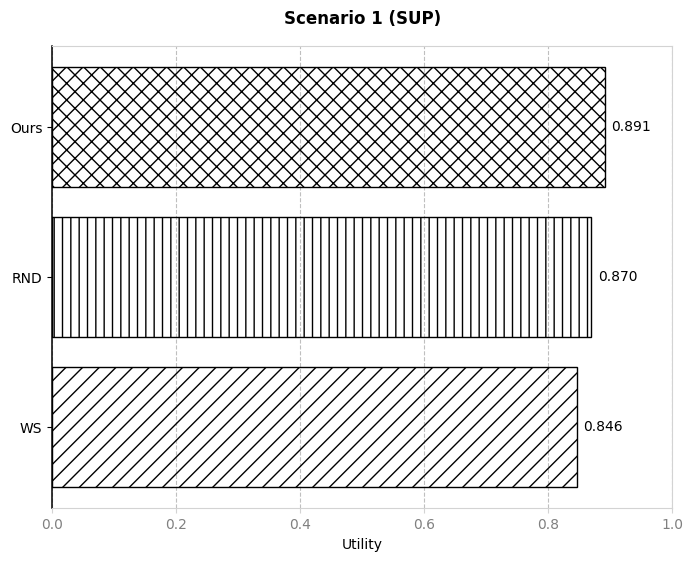

In [81]:
# Visualize results for scenario 1 in a horizontal bar chart
def visualize_results(data, title):
    """Visualize the results for scenario 1."""
    # Get figure
    fig, ax = plt.subplots(figsize=(8, 6))
    # Set title
    ax.set_title(title, fontweight="bold", pad=16)
    # Set x-axis
    ax.set_xlabel("Utility")
    # Set y-axis
    # ax.set_ylabel("Solver")
    # Set grid
    ax.set_axisbelow(True)
    ax.grid(color='gray', linestyle='dashed', axis="x", alpha=0.5)
    # Set limits
    ax.set_xlim(0, 1)
    # Set spines to grey
    ax.spines["bottom"].set_color('lightgray')
    ax.spines["top"].set_color('lightgray')
    ax.spines["right"].set_color('lightgray')
    ax.spines["left"].set_color('k')
    # Set the left spine to be thick
    ax.spines["left"].set_linewidth(1.1)
    # Set the tick labels and axis labels color to grey
    ax.tick_params(axis="x", which="both", labelcolor='gray', color='lightgray')
    # Plot bars
    hatches = ["//", "||", "xx", "++", "oo", "**"]
    ax.barh(data["solver"], data["utility"],
        edgecolor="k",
        color="none",
        hatch=data["solver"].map(dict(zip(data["solver"].unique(), hatches))),
    )
    # Set y-axis
    ax.set_yticks(data["solver"])
    ax.set_yticklabels(data["solver"])
    # Set labels
    for i, (solver, utility) in enumerate(zip(data["solver"], data["utility"])):
        ax.text(utility + 0.01, i, f"{utility:.3f}", ha="left", va="center", color="k")
    # Return figure
    return fig

def visualize_scenario_1(results):
    """Visualize the results for scenario 1."""
    # Get data
    data = results[results["scenario"] == "SUP"].sort_values(by=["scenario", "utility"], ascending=True)
    # Get figure
    fig = visualize_results(data, "Scenario 1 (SUP)")
    # Return figure
    return fig

fig_scenario_1 = visualize_scenario_1(results)
plt.show(fig_scenario_1)
